In [1]:
import pandas as pd

# spajam tripStopTimes sa stops da bih za stajalista imala informaciju za smer(direction_id)

tripStopTimesPath = "../Desktop/sredjeniPodaci/tripStopTimes.txt"
tripStopTimes = pd.read_csv(tripStopTimesPath, sep='\t')

stopsPath = "../Desktop/asmPodaci/stops.txt"
stops = pd.read_csv(stopsPath)

# izbacujem nebitne kolone
stops.drop('zone_id', inplace=True, axis=1)
stops.drop('stop_url', inplace=True, axis=1)
stops.drop('location_type', inplace=True, axis=1)
stops.drop('stop_desc', inplace=True, axis=1)
stops.drop('stop_code', inplace=True, axis=1)
stops.drop('parent_station', inplace=True, axis=1)
stops.drop('stop_timezone', inplace=True, axis=1)
stops.drop('wheelchair_boarding', inplace=True, axis=1)

mergedTripStopTimes = tripStopTimes.merge(stops, on='stop_id', how='inner')

# uklanjam duplikate - opet se dobije 3130 stajalista
mergedTripStopTimes = mergedTripStopTimes.drop_duplicates(subset=['stop_id', 'stop_name'])

mergedTripStopTimes.to_csv("mergedTripStopTimes.txt", sep='\t')

In [2]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlat = lat1_rad - lat2_rad
    dlon = lon1_rad - lon2_rad
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distance = R * c
    return distance

# prosecna brzina pesacenja u km/h
average_walking_speed_kmph = 5.0

grouped = mergedTripStopTimes.groupby(['direction_id', 'stop_name'])
all_means = []

for group_name, group_data in grouped:
    latitudes = group_data['stop_lat'].values
    longitudes = group_data['stop_lon'].values
    
    times = []
    if len(group_data) > 1:
        for i in range(len(latitudes)):
            for j in range(len(latitudes)):
                if i != j:
                    lat1, lon1 = latitudes[i], longitudes[i]
                    lat2, lon2 = latitudes[j], longitudes[j]

                    distance = haversine(lat1, lon1, lat2, lon2)

                    time = (distance / average_walking_speed_kmph) * 60
                    # postoje neke stanice(npr. zeleznicka stanica) koje su dosta udaljenje, pa ogranicavam vreme
                    if(time < 15):
                        times.append(time)
                        unique_times = list(set(times))
    
        # izracunavanje prosecnog vremena za sve kombinacije stajalista u grupi
        mean_time = np.mean(unique_times)

        all_means.append(mean_time)

# izracunavanje prosecnog vremena za sve grupe
overall_mean_time = np.mean(all_means)
print("Prosecno vreme:", overall_mean_time)
 

Prosecno vreme: 2.8550042578401005


In [3]:
tripStopTimesPath = "../Desktop/sredjeniPodaci/tripStopTimes.txt"
tripStopTimes = pd.read_csv(tripStopTimesPath, sep='\t')

# prethodnom analizom sam zakljucila da sve nocne linije pocinju sa 50, 51, 52 ili 53 i posle imaju vrednost vecu od 15
# izbacujem nocne linije jer se u zadatku trazi ispitivanje za dnevni rezim
tripStopTimes = tripStopTimes[~(((tripStopTimes['route_id'].astype(str).str.startswith('50')) & (tripStopTimes['route_id'] >= 50015)) |
                    ((tripStopTimes['route_id'].astype(str).str.startswith('51')) & (tripStopTimes['route_id'] >= 51015)) |
                    ((tripStopTimes['route_id'].astype(str).str.startswith('52')) & (tripStopTimes['route_id'] >= 52015)) |
                    ((tripStopTimes['route_id'].astype(str).str.startswith('53')) & (tripStopTimes['route_id'] >= 53015)))]

# postoje stop_id koji su NaN, pa te vrednosti izbacujem, da se ne bi stvarali dodatni cvorovi
tripStopTimes = tripStopTimes.dropna(subset=['stop_id'])

In [4]:
directionZero = mergedTripStopTimes[mergedTripStopTimes['direction_id'] == 0]

directionZero = directionZero.sort_values(by=['stop_lat', 'stop_lon'], ascending=[False, False])

for index1, row1 in directionZero.iterrows():
    lat1 = row1['stop_lat']
    lon1 = row1['stop_lon']
    for index2, row2 in directionZero.iterrows():
        if index1 == index2:
            continue
        lat2 = row2['stop_lat']
        lon2 = row2['stop_lon']
        distance = haversine(lat1, lon1, lat2, lon2)
        time = (distance / average_walking_speed_kmph) * 60
        if(time < 3):
            #print(time)
            directionZero.loc[index2, 'stop_id'] = f"{row1['stop_id']}"
            
            # Definišite uslov za zamenu starih vrednosti u koloni 'stop_id'
            condition = tripStopTimes['stop_id'] == row2['stop_id']  # Zamena vrednosti 'stari_stop_id'

            # Postavite nove vrednosti u odgovarajuće redove
            tripStopTimes.loc[condition, 'stop_id'] = f"{row1['stop_id']}"


In [5]:
directionOne = mergedTripStopTimes[mergedTripStopTimes['direction_id'] == 1]

directionOne = directionOne.sort_values(by=['stop_lat', 'stop_lon'], ascending=[False, False])

for index1, row1 in directionOne.iterrows():
    lat1 = row1['stop_lat']
    lon1 = row1['stop_lon']
    for index2, row2 in directionOne.iterrows():
        if index1 == index2:
            continue
        lat2 = row2['stop_lat']
        lon2 = row2['stop_lon']
        distance = haversine(lat1, lon1, lat2, lon2)
        time = (distance / average_walking_speed_kmph) * 60
        if(time < 3):
            #print(time)
            directionOne.loc[index2, 'stop_id'] = f"{row1['stop_id']}"
            
            # Definišite uslov za zamenu starih vrednosti u koloni 'stop_id'
            condition = tripStopTimes['stop_id'] == row2['stop_id']  # Zamena vrednosti 'stari_stop_id'

            # Postavite nove vrednosti u odgovarajuće redove
            tripStopTimes.loc[condition, 'stop_id'] = f"{row1['stop_id']}"


In [6]:
directionZero.to_csv("directionZero.txt", sep='\t')
directionOne.to_csv("directionOne.txt", sep='\t')

broj_jedinstvenih_stop_id = tripStopTimes['stop_id'].nunique()

# Ispis rezultata
print(f"Broj jedinstvenih stop_id: {broj_jedinstvenih_stop_id}")

Broj jedinstvenih stop_id: 2586


In [30]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# neusmeren beztezinski graf
G = nx.Graph()

# KREIRANJE CVOROVA

# spajam directionZero i directionOne u jednu tabelu
zeroPlusOne = pd.concat([directionZero, directionOne], ignore_index=True)
# print(zeroPlusOne['stop_id'].nunique())

for stop in zeroPlusOne.itertuples(index=False):
    stop_id = stop.stop_id
    stop_name = stop.stop_name
    stop_lat = stop.stop_lat
    stop_lon = stop.stop_lon
    G.add_node(stop_id, name=stop_name, lat=stop_lat, lon=stop_lon)

# KREIRANJE GRANA
    
# SPAJANJE KRAJNJIH STANICA SADA NE TREBA JER SU UGLAVNOM TE STANICE BLIZU I ONDA SU SPOJENE U JEDAN CVOR
# PA DA SE NE BI STVARALI SELF LOOPS

# sortiram po trip_id i stop_sequence
tripStopTimesSorted = tripStopTimes.sort_values(by=['trip_id', 'stop_sequence'])

# dodajem kolonu 'next_stop_id' sa sledecim stop_id
tripStopTimesSorted['next_stop_id'] = tripStopTimesSorted.groupby(['trip_id', 'route_id'])['stop_id'].shift(-1)

tripStopTimesSorted = tripStopTimesSorted[tripStopTimesSorted['stop_id'] != tripStopTimesSorted['next_stop_id']]
#print(tripStopTimesSorted)
#tripStopTimesSorted.to_csv("tstsorted.txt", sep='\t')
# Filtriranje i izbacivanje NaN vrednosti
filtered_data = tripStopTimesSorted.dropna(subset=['next_stop_id'])

# Konverzija podataka u listu tuplova
edges = list(filtered_data[['stop_id', 'next_stop_id']].itertuples(index=False, name=None))

# Dodavanje grana u graf
G.add_edges_from(edges)

         trip_id  route_id        service_id   trip_headsign  direction_id  \
0         665800       401    Zimski-Nedelja        Pinosava             0   
1         665800       401    Zimski-Nedelja        Pinosava             0   
2         665800       401    Zimski-Nedelja        Pinosava             0   
3         665800       401    Zimski-Nedelja        Pinosava             0   
4         665800       401    Zimski-Nedelja        Pinosava             0   
...          ...       ...               ...             ...           ...   
1648800  1494173       101  Zimski-Radni Dan  Padinska Skela             0   
1648801  1494173       101  Zimski-Radni Dan  Padinska Skela             0   
1648802  1494173       101  Zimski-Radni Dan  Padinska Skela             0   
1648803  1494173       101  Zimski-Radni Dan  Padinska Skela             0   
1648804  1494173       101  Zimski-Radni Dan  Padinska Skela             0   

        arrival_time stop_id  stop_sequence next_stop_id  
0   

In [31]:
print("Broj čvorova (stajališta):", G.number_of_nodes())
print("Broj grana:", G.number_of_edges())

# Pronalaženje čvorova sa self loop
nodes_with_selfloops = [node for node in G.nodes if G.has_edge(node, node)]

# Ispisivanje čvorova sa self loop
print("Čvorovi sa self loop:")
for node in nodes_with_selfloops:
    print(node)

Broj čvorova (stajališta): 2830
Broj grana: 3285
Čvorovi sa self loop:


In [32]:
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

Br povezanih komponenti:  245
Velicine povezanih komp:  [2586, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [33]:
# uklanjanjam sve nepovezane komponente

connected_components = list(nx.connected_components(G))

# komponente sa veličinom 1
components_to_remove = [component for component in connected_components if len(component) == 1]

for component in components_to_remove:
    G.remove_nodes_from(component)
    
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

Br povezanih komponenti:  1
Velicine povezanih komp:  [2586]


In [35]:
output_path = "../Desktop/asmPodaci/LWalkgraph.gml"

nx.write_gml(G, output_path)

In [34]:
numOfNodes = G.number_of_nodes()
numOfEdges = G.number_of_edges()

density = 2 * numOfEdges / (numOfNodes * (numOfNodes - 1))

print("Gustina L mreze:", density)

Gustina L mreze: 0.000982825241106329


In [36]:
averageDistance = nx.average_shortest_path_length(G)
diameter = nx.diameter(G)

print("Prosecna distanca:", averageDistance)
print("Dijametar:", diameter)

Prosecna distanca: 25.296343501161587
Dijametar: 102


In [37]:
# br povezanih komponenti
numOfConnectedComponents = nx.number_connected_components(G)
print("Br povezanih komponenti: ", numOfConnectedComponents)

# velicina povezanih komponenata
sizeOfConnectedComponents = [len(component) for component in nx.connected_components(G)]
print("Velicine povezanih komp: ", sizeOfConnectedComponents)

# provera postojanja gigantske komp
hasGiantComponent = max(sizeOfConnectedComponents) > 1
print("Postoji gigantska komp: ", hasGiantComponent)

# izracunavanje centralizacije
max_degree = max(dict(G.degree()).values()) # sadrzi cvorove kao kljuceve i njihov stepen kao vrednost
centralization = (sum([max_degree - degree for degree in dict(G.degree()).values()])) / ((len(G) - 1) * (len(G) - 2))
print("Centralizacija:", centralization)

Br povezanih komponenti:  1
Velicine povezanih komp:  [2586]
Postoji gigantska komp:  True
Centralizacija: 0.006759346312076699


Prosečni koef klasterizacije: 0.03029919256214574
Globalni koef klasterizacije: 0.06696428571428571


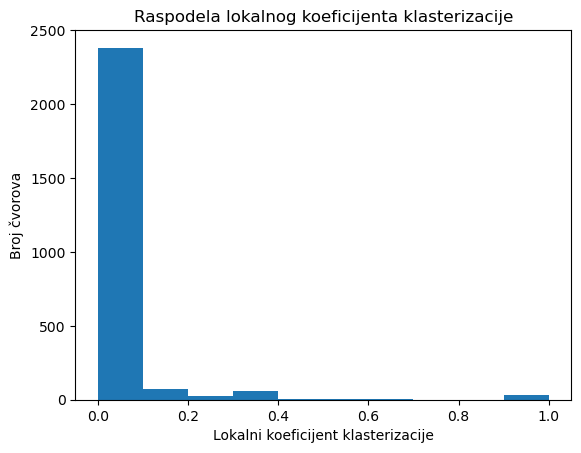

Prosečni koeficijent klasterizacije (Erdos-Renyi): 0.20023581778184976
Prosečni koeficijent klasterizacije (Scale-free): 0.013816133961998964


In [38]:
averageClusteringCoef = nx.average_clustering(G)
globalClusteringCoef = nx.transitivity(G) # compute graph transitivity, the fraction of all possible triangles present in G

print("Prosečni koef klasterizacije:", averageClusteringCoef)
print("Globalni koef klasterizacije:", globalClusteringCoef)

localClusteringCoeffs = nx.clustering(G)
plt.hist(list(localClusteringCoeffs.values()), bins=10)
plt.xlabel('Lokalni koeficijent klasterizacije')
plt.ylabel('Broj čvorova')
plt.title('Raspodela lokalnog koeficijenta klasterizacije')
plt.show()

# Generisanje Erdos-Renyi mreže
erdosRenyiGraph = nx.erdos_renyi_graph(n=len(G.nodes), p=0.2)
erdosRenyiAvgClustering = nx.average_clustering(erdosRenyiGraph)

# Generisanje scale-free mreže
scaleFreeGraph = nx.barabasi_albert_graph(n=len(G.nodes), m=2)
scaleFreeAvgClustering = nx.average_clustering(scaleFreeGraph)

print("Prosečni koeficijent klasterizacije (Erdos-Renyi):", erdosRenyiAvgClustering)
print("Prosečni koeficijent klasterizacije (Scale-free):", scaleFreeAvgClustering)

In [39]:
# izracunavanje koef asortativnosti
assortativity = nx.degree_assortativity_coefficient(G)
print("Koeficijent asortativnosti:", assortativity)

output_path = "../Desktop/asmPodaci/Lgraph.gml"

nx.write_gml(G, output_path)

Koeficijent asortativnosti: 0.2875982702579338


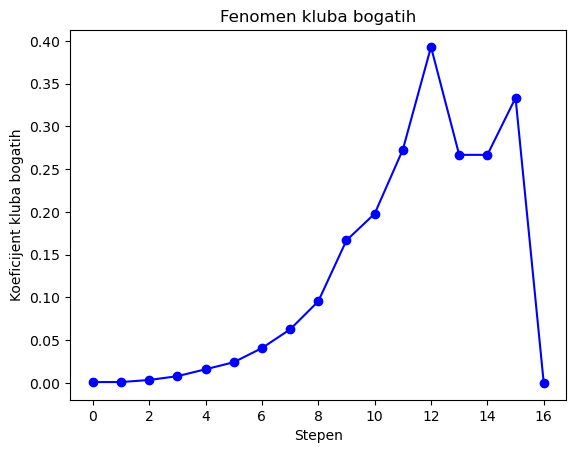

Mreža ne ispoljava rich club phenomenon.


In [40]:
richClubCoeffs = nx.rich_club_coefficient(G, normalized=False)

plt.plot(list(richClubCoeffs.keys()), list(richClubCoeffs.values()), 'bo-')
plt.xlabel('Stepen')
plt.ylabel('Koeficijent kluba bogatih')
plt.title('Fenomen kluba bogatih')
plt.show()

if max(richClubCoeffs.values()) > 1:
    print("Mreža ispoljava rich club phenomenon.")
else:
    print("Mreža ne ispoljava rich club phenomenon.")

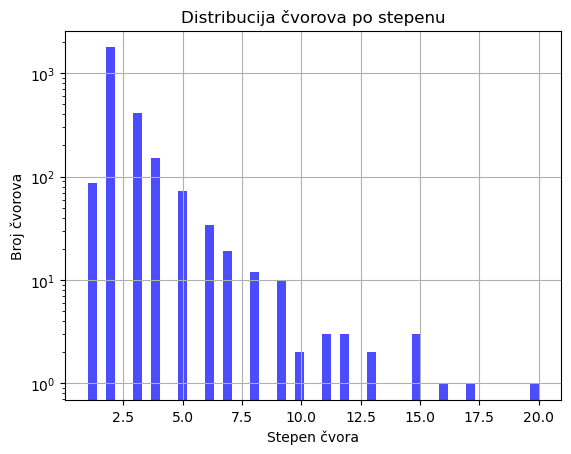

In [41]:
# Izračunavanje distribucije čvorova po stepenu
degree_distribution = dict(G.degree())

# Izračunavanje histograma distribucije čvorova po stepenu
degree_values = list(degree_distribution.values())
plt.hist(degree_values, bins=50, log=True, color='b', alpha=0.7)

# Podešavanje grafičkih elemenata
plt.xlabel('Stepen čvora')
plt.ylabel('Broj čvorova')
plt.title('Distribucija čvorova po stepenu')
plt.grid(True)

# Prikazivanje histograma
plt.show()

In [42]:
# Analiza centralnosti po stepenu
degree_centrality = nx.degree_centrality(G)

# centralnost po bliskosti
closeness_centrality = nx.closeness_centrality(G)

# relacionа centralnost
betweenness_centrality = nx.betweenness_centrality(G)

# Centralnost po stepenu sortirano
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po centralnosti po stepenu:")
print(sorted_degree_centrality[:10])

# Centralnost po bliskosti sortirano
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po centralnosti po bliskosti:")
print(sorted_closeness_centrality[:10])

# Relaciona centralnost sortirano
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Najvažniji akteri po relacionoj centralnosti:")
print(sorted_betweenness_centrality[:10])  # Prikaz prvih 10 najvažnijih aktera

Najvažniji akteri po centralnosti po stepenu:
[('86.0', 0.007736943907156673), ('3028.0', 0.006576402321083172), ('2353.0', 0.006189555125725338), ('533.0', 0.005802707930367505), ('936.0', 0.005802707930367505), ('141.0', 0.005802707930367505), ('532.0', 0.005029013539651838), ('10.0', 0.005029013539651838), ('128.0', 0.0046421663442940036), ('583.0', 0.0046421663442940036)]
Najvažniji akteri po centralnosti po bliskosti:
[('3107.0', 0.06717600893947663), ('780.0', 0.06700362882322447), ('395.0', 0.06680277031217696), (397.0, 0.06647123865360385), (398.0, 0.06642341393221471), ('2353.0', 0.06628035178585165), ('3028.0', 0.06624298490633729), ('936.0', 0.06608886843585417), ('396.0', 0.06606015690884465), (271.0, 0.06565913131826263)]
Najvažniji akteri po relacionoj centralnosti:
[('2353.0', 0.23488654200958056), (1652.0, 0.17310776439043699), ('780.0', 0.15372210330956979), ('391.0', 0.15103645223658504), (307.0, 0.14834564153746974), ('2522.0', 0.14412804550040448), ('1836.0', 0.1414

In [43]:
# Računanje vrednosti centralnosti po sopstvenom vektoru
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sortiranje
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Prikazivanje najvažnijih čvorova
print("Najvažniji čvorovi po centralnosti po sopstvenom vektoru:")
print(sorted_eigenvector_centrality[:10])

Najvažniji čvorovi po centralnosti po sopstvenom vektoru:
[('86.0', 0.37889144569706446), ('533.0', 0.31365917019051043), ('583.0', 0.2930325195812989), ('532.0', 0.29088938252100194), ('2353.0', 0.2899361712137958), ('10.0', 0.22574597682373568), ('936.0', 0.21551029625847207), ('114.0', 0.2136316546828186), ('1216.0', 0.20453100733176335), ('147.0', 0.19563793346147923)]


In [44]:
weight_degree = 1
weight_closeness = 0.5
weight_betweenness = 0.8
weight_eigenvector = 0.3

# Izračunavanje kompozitne mere centralnosti za svaki čvor
composite_centrality = {}
for node in G.nodes():
    composite_centrality[node] = (
        weight_degree * degree_centrality[node] +
        weight_closeness * closeness_centrality[node] +
        weight_betweenness * betweenness_centrality[node] +
        weight_eigenvector * eigenvector_centrality[node]
    )

# Sortiranje čvorova
sorted_composite_centrality = sorted(composite_centrality.items(), key=lambda x: x[1], reverse=True)

# Prikazivanje najvažnijih čvorova
print("Najvažniji čvorovi prema kompozitnoj meri centralnosti:")
print(sorted_composite_centrality[:10])

Najvažniji čvorovi prema kompozitnoj meri centralnosti:
[('2353.0', 0.31421981599045434), ('86.0', 0.24305025283862916), (1652.0, 0.1762853043616471), ('780.0', 0.17003811396815807), (307.0, 0.16696657463640735), ('533.0', 0.16410954260756502), ('3028.0', 0.15921776401749665), ('10.0', 0.15827556117481986), ('391.0', 0.1570566926775389), ('936.0', 0.15392303997823925)]
